In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random
import cv2
from os import listdir
from os.path import isfile, join

In [ ]:
seed_train_validation = 123
train_ds = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/Data/Sport Images/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=5,
    image_size=(256, 256),
    shuffle=True,
    seed=seed_train_validation,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/Data/Sport Images/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=5,
    image_size=(256, 256),
    shuffle=True,
    seed=seed_train_validation,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take((val_batches) // 2)
val_ds = validation_ds.skip((val_batches) // 2)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Found 3279 files belonging to 5 classes.
Using 2296 files for training.
Found 3279 files belonging to 5 classes.
Using 983 files for validation.
Number of training samples: 460
Number of validation samples: 99
Number of test samples: 98


In [ ]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),]
)

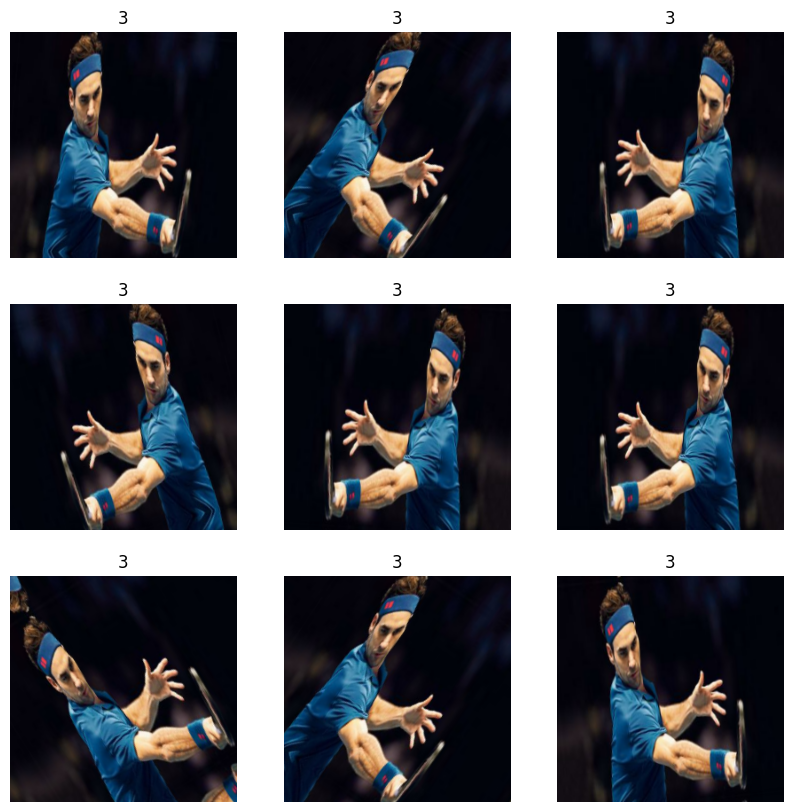

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
def model_define(model_name):
  if model_name == 'ResNet50V2':
    base_applications = keras.applications.ResNet50V2
  elif model_name == 'EfficientNetB0':
    base_applications = keras.applications.EfficientNetB0
  elif model_name == 'VGG16':
    base_applications = keras.applications.VGG16
  else:
    print("model_name must one of ResNet50V2, EfficientNetB0 or VGG16")
    return 

  base_model = base_applications(
      weights="imagenet",
      input_shape=(256, 256, 3),
      include_top=False,
  )

  base_model.trainable = False
  inputs = keras.Input(shape=(256, 256, 3))
  x = data_augmentation(inputs)

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)
  x = base_model(x, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(5)(x)
  model = keras.Model(inputs, outputs)
  model.summary()
  return model

def model_train(model_name, train_ds, validation_ds, epochs=50):
  print("Training model %s"%model_name)
  model = model_define(model_name)
  checkpoint_filepath = 'model/'+ model_name +'/weights.{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5'

  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_sparse_categorical_accuracy',
      mode='max',
      save_best_only=True)

  early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5)

  history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[early_stop_callback, model_checkpoint_callback])
 
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('%s accuracy'%model_name)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  return history

def get_best_model(root_dir):
  best_model = ""
  max_acc = 0
  for file in listdir(root_dir):
    if float(file.split('-')[-1][:4]) > max_acc:
      best_model = file
      max_acc = float(file.split('-')[-1][:4])
  print("find best model %s"%join(root_dir, best_model))
  return join(root_dir, best_model)

def model_predict(model_name, root_dir, train_ds, trainable=False):
  model = model_define(model_name)
  model.trainable = trainable
  # load model
  best_model_weight_path = get_best_model(root_dir)
  model.load_weights(best_model_weight_path)
  model.summary()
  print("Load %s model success!"%model_name)
  # predict model
  predict_labels = []
  true_labels = []
  for x, y in train_ds:
    y_prediction = model.predict(x)
    # y_prediction = np.argmax(y_prediction, axis=1)
    y_prediction = y_prediction.argmax(axis=-1)
    predict_labels += list(y_prediction)
    true_labels += y.numpy().tolist()
  return predict_labels, true_labels

def report(predict_labels, true_labels, target_names):
  confusion_matrix_res = confusion_matrix(true_labels, predict_labels, normalize='pred')
  print('confusion matrix:\n', confusion_matrix_res)
  classification_report_res = classification_report(true_labels, predict_labels, target_names=target_names)
  print('classification report:\n', classification_report_res)

Training model ResNet50V2
94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 

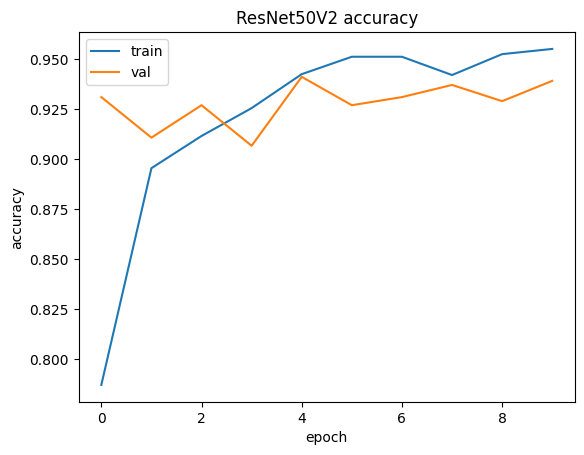

Training model EfficientNetB0
16705208/16705208 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (

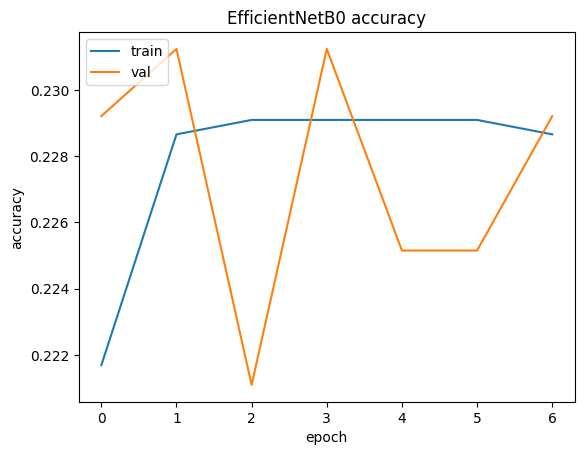

Training model VGG16
58889256/58889256 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)

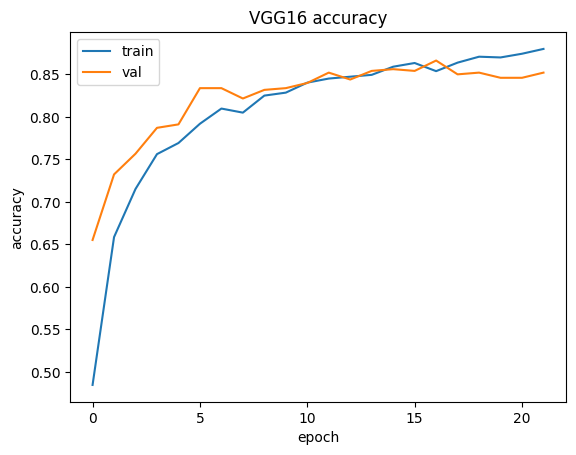

In [ ]:
history = model_train('ResNet50V2', train_ds, val_ds, 100)
history = model_train('EfficientNetB0', train_ds, val_ds, 100)
history = model_train('VGG16', train_ds, val_ds, 100)

In [ ]:
ResNet50V2_predict_labels_train, ResNet50V2_true_labels_train = model_predict('ResNet50V2', 'model/ResNet50V2/', train_ds, False)
ResNet50V2_predict_labels_test, ResNet50V2_true_labels_test = model_predict('ResNet50V2', 'model/ResNet50V2/', test_ds, False)
EfficientNetB0_predict_labels_train, EfficientNetB0_true_labels_train = model_predict('EfficientNetB0', 'model/EfficientNetB0/', train_ds, False)
EfficientNetB0_predict_labels_test, EfficientNetB0_true_labels_test = model_predict('EfficientNetB0', 'model/EfficientNetB0/', test_ds, False)
VGG16_predict_labels_train, VGG16_true_labels_train = model_predict('VGG16', 'model/VGG16/', train_ds, False)
VGG16_predict_labels_test, VGG16_true_labels_test = model_predict('VGG16', 'model/VGG16/', test_ds, False)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                65568     
                                                           

In [ ]:
target_names=train_ds.class_names

# ResNet50V2
print("Train Confusion matrix and classification report for ResNet50V2")
report(ResNet50V2_predict_labels_train, ResNet50V2_true_labels_train, target_names)
print("Test Confusion matrix and classification report for ResNet50V2")
report(ResNet50V2_predict_labels_test, ResNet50V2_true_labels_test, target_names)

# EfficientNetB0
print("Train Confusion matrix and classification report for EfficientNetB0")
report(EfficientNetB0_predict_labels_train, EfficientNetB0_true_labels_train, target_names)
print("Test Confusion matrix and classification report for EfficientNetB0")
report(EfficientNetB0_predict_labels_test, EfficientNetB0_true_labels_test, target_names)

# VGG16
print("Train Confusion matrix and classification report for VGG16")
report(VGG16_predict_labels_train, VGG16_true_labels_train, target_names)
print("Test Confusion matrix and classification report for VGG16")
report(VGG16_predict_labels_test, VGG16_true_labels_test, target_names)

Train Confusion matrix and classification report for ResNet50V2
confusion matrix:
 [[0.96666667 0.         0.         0.00440529 0.00403226]
 [0.00185185 0.95555556 0.00224215 0.         0.0141129 ]
 [0.         0.00555556 0.97533632 0.00220264 0.00806452]
 [0.02962963 0.02777778 0.00224215 0.99339207 0.00201613]
 [0.00185185 0.01111111 0.02017937 0.         0.97177419]]
classification report:
               precision    recall  f1-score   support

    baseball       0.97      0.99      0.98       526
  basketball       0.96      0.97      0.96       353
     fencing       0.98      0.98      0.98       442
      tennis       0.99      0.94      0.97       479
  volleyball       0.97      0.97      0.97       496

    accuracy                           0.97      2296
   macro avg       0.97      0.97      0.97      2296
weighted avg       0.97      0.97      0.97      2296

Test Confusion matrix and classification report for ResNet50V2
confusion matrix:
 [[0.95       0.         0.02   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
def finetune_model(model_name, root_dir, train_ds, validation_ds, epochs):
  print("Finetune model %s"%model_name)
  model = model_define(model_name)

  # load model
  best_model_weight_path = get_best_model(root_dir)
  model.load_weights(best_model_weight_path)
  model.trainable = True
  model.summary()

  model.compile(
      optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )

  checkpoint_filepath = 'model/finetune/'+ model_name +'/weights.{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

  early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2)
  history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[early_stop_callback, model_checkpoint_callback])
  return history

In [ ]:
train_all_ds = tf.keras.utils.image_dataset_from_directory(
    'drive/MyDrive/Data/Sport Images/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=5,
    image_size=(256, 256),
    shuffle=True,
    seed=seed_train_validation,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

ResNet50V2_finetune_result = finetune_model('ResNet50V2', 'model/ResNet50V2/', train_all_ds, validation_ds, 10)
EfficientNetB0_finetune_result = finetune_model('EfficientNetB0', 'model/EfficientNetB0/', train_all_ds, validation_ds, 20)
VGG16_finetune_result = finetune_model('VGG16', 'model/VGG16/', train_all_ds, validation_ds, 20)

Found 3279 files belonging to 5 classes.
Finetune model ResNet50V2
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 32)                655

In [ ]:
def format_frames(frame, output_size):
  frame = tf.image.resize(frame, output_size)
  return frame

def frames_from_video_file(video_path, n_frames=-1, output_size = (224,224), frame_step = 15):
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  cnt = 0
  while src.isOpened() and (n_frames == -1 or len(result) < n_frames) and cnt < 1000:
      ret, frame = src.read()
      if ret:
          frame = format_frames(frame, output_size)
          result.append(frame)
      else:
        cnt +=1

  src.release()
  result = np.array(result)[..., [2, 1, 0]]
  # print(result.shape)
  return result

def get_class_label(dname):
  if dname == 'BaseballPitch':
    class_name = 'baseball'
    label = 0
  elif dname == 'Basketball':
    class_name = 'basketball'
    label = 1
  elif dname == 'Fencing':
    class_name = 'fencing'
    label = 2
  elif dname == 'TennisSwing':
    class_name = 'tennis'
    label = 3
  elif dname == 'VolleyballSpiking':
    class_name = 'volleyball'
    label = 4
  else:
    class_name = ''
    label = -1
  return class_name, label

def video_model_predict(model_name, root_dir, batch_size = 32, n_frames = 100, output_size = (256, 256), trainable=False):
  print("model predict for video %s" % model_name)
  model = model_define(model_name)
  model.trainable = trainable

  # load model
  best_model_weight_path = get_best_model(root_dir)
  model.load_weights(best_model_weight_path)
  model.summary()
  print("Load success!")

  # predict model
  predict_labels = []
  true_labels = []
  src_file_path = 'drive/MyDrive/Data/Sport Videos/'
  cnt = 0
  for dir in listdir(src_file_path):
    class_name, label = get_class_label(dir)
    if label >= 0:
      for f in listdir(join(src_file_path, dir)):
        if '.avi' in f:
          avi_file_path = join(src_file_path, dir, f)
          sample_video = frames_from_video_file(avi_file_path, n_frames, output_size)
          # print(sample_video.shape)
          y_prediction = model.predict(sample_video, batch_size=batch_size)
          # print(y_prediction)
          y_prediction = np.average(y_prediction, axis=0)
          y_prediction = np.argmax(y_prediction)
          predict_labels.append(y_prediction)
          true_labels.append(label)
          cnt += 1
        if cnt %100 == 0:
          print("processing %d" % cnt)        
  print("processing done, total size: %d"%cnt)
  return predict_labels, true_labels

In [ ]:
ResNet50V2_predict_labels_video_data, ResNet50V2_true_labels_video_data = video_model_predict('ResNet50V2', 'model/finetune/ResNet50V2/', trainable=True)
EfficientNetB0_predict_labels_video_data, EfficientNetB0_true_labels_video_data = video_model_predict('EfficientNetB0', 'model/finetune/EfficientNetB0/',  trainable=True)
VGG16_predict_labels_video_data, VGG16_true_labels_video_data = video_model_predict('VGG16', 'model/finetune/VGG16/', batch_size=10, trainable=True)

model predict for video ResNet50V2
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_31 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_21  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_42 (Dense)            (None, 32)                65568     
                       

In [ ]:
target_names=train_ds.class_names

# ResNet50V2 for video
print("Video Confusion matrix and classification report for ResNet50V2")
report(ResNet50V2_predict_labels_video_data, ResNet50V2_true_labels_video_data, target_names)

# EfficientNetB0 for video
print("Video Confusion matrix and classification report for EfficientNetB0")
report(EfficientNetB0_predict_labels_video_data, EfficientNetB0_true_labels_video_data, target_names)

# VGG16 for video
print("Video Confusion matrix and classification report for VGG16")
report(VGG16_predict_labels_video_data, VGG16_true_labels_video_data, target_names)

Video Confusion matrix and classification report for ResNet50V2
confusion matrix:
 [[0.79532164 0.         0.04034582 0.         0.        ]
 [0.16374269 0.         0.26512968 0.06015038 0.3       ]
 [0.         0.         0.31988473 0.         0.        ]
 [0.         0.         0.12103746 0.93984962 0.        ]
 [0.04093567 0.         0.25360231 0.         0.7       ]]
classification report:
               precision    recall  f1-score   support

    baseball       0.80      0.91      0.85       150
  basketball       0.00      0.00      0.00       137
     fencing       0.32      1.00      0.48       111
      tennis       0.94      0.75      0.83       167
  volleyball       0.70      0.18      0.29       116

    accuracy                           0.58       681
   macro avg       0.55      0.57      0.49       681
weighted avg       0.58      0.58      0.52       681

Video Confusion matrix and classification report for EfficientNetB0
confusion matrix:
 [[0.52401747 0.         0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif